# Omron's Incentive Mechanism
The below demonstration provides an illustration of Omron's incentive mechanism. This incentive mechanism operates within a zero knowledge proof system, allowing validators to trustlessly prove their scoring within the subnet.

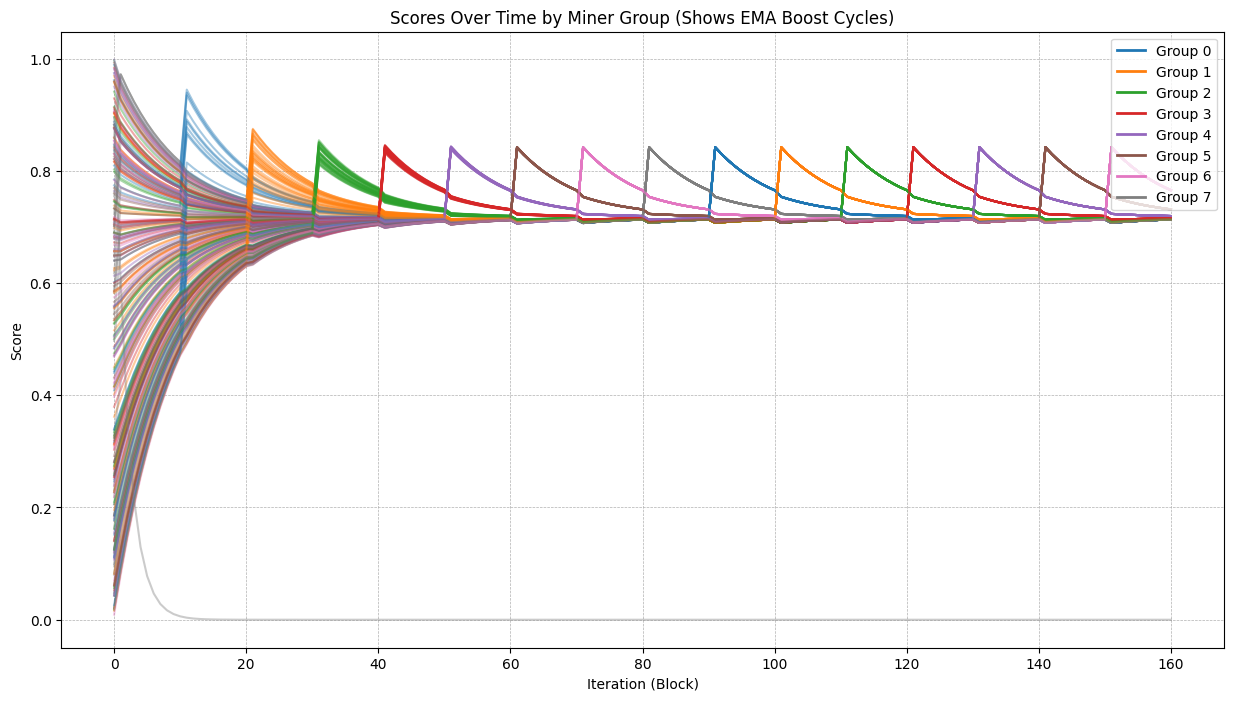

/var/folders/by/whcxqk1j1dq0qrcy975ljpsw0000gn/T/ipykernel_2172/2091110206.py:295: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


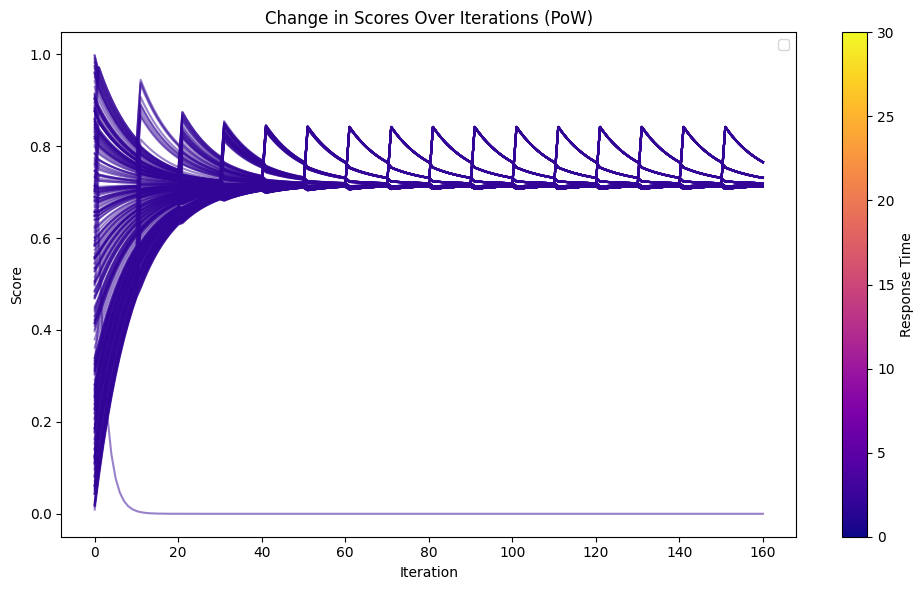

IndexError: tensors used as indices must be long, int, byte or bool tensors

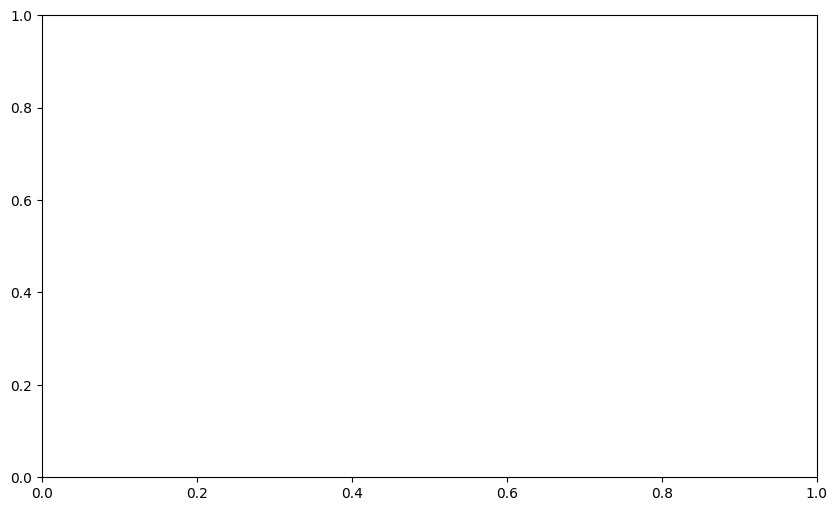

In [ ]:
import torch
import random
import logging
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import json
import bittensor as bt
import numpy as np
from matplotlib.lines import Line2D
from _validator.scoring.reward import FLATTENING_COEFFICIENT, MAXIMUM_RESPONSE_TIME_DECIMAL, PROOF_SIZE_THRESHOLD, PROOF_SIZE_WEIGHT, RATE_OF_DECAY, RATE_OF_RECOVERY, Reward
from deployment_layer.circuit_store import circuit_store

from constants import BATCHED_PROOF_OF_WEIGHTS_MODEL_ID, SINGLE_PROOF_OF_WEIGHTS_MODEL_ID, NUM_MINER_GROUPS
from execution_layer.verified_model_session import VerifiedModelSession
from execution_layer.circuit import Circuit
from execution_layer.circuit_metadata import ProofSystem
from _validator.models.request_type import RequestType
from execution_layer.generic_input import GenericInput

COMPETITION_WEIGHT = 0
RESPONSE_TIME_WEIGHT = 1
MAX_RESPONSE_TIME = 30
MIN_RESPONSE_TIME = 0
MAX_SCORE = 1
BATCH_SIZE = 256
ENABLE_LOGS = False
CIRCUIT_ONLY = True

# EMA and epoch simulation constants
EPOCH_TEMPO = 10  # Blocks per epoch for simulation
PLOT_INTERVALS = NUM_MINER_GROUPS * EPOCH_TEMPO * 2  # 2 full cycles

# Disable intervention flags to focus on EMA
FIX_TIMES_AFTER_INTERVAL = False
FIX_COMPETITION_AFTER_INTERVAL = False

MODEL_ID = SINGLE_PROOF_OF_WEIGHTS_MODEL_ID if BATCH_SIZE == 256 else BATCHED_PROOF_OF_WEIGHTS_MODEL_ID
circuit = Circuit(MODEL_ID)
if ENABLE_LOGS:
    bt.logging.on()
else:
    bt.logging.off()
    logging.disable(logging.CRITICAL)

def log(message: str) -> None:
    if ENABLE_LOGS:
        print(message)


def run_inference_via_proof_system(
    batch_inputs: Dict[str, torch.Tensor]
) -> torch.Tensor:
    if not circuit:
        raise ValueError("Circuit is not available.")
    if not circuit.settings:
        raise ValueError("Circuit settings are not available.")
    scale = circuit.settings["scaling"]

    modified_inputs = {
        "RATE_OF_DECAY": int(RATE_OF_DECAY * scale),
        "RATE_OF_RECOVERY": int(RATE_OF_RECOVERY * scale),
        "FLATTENING_COEFFICIENT": int(FLATTENING_COEFFICIENT * scale),
        "PROOF_SIZE_WEIGHT": int(PROOF_SIZE_WEIGHT * scale),
        "PROOF_SIZE_THRESHOLD": int(PROOF_SIZE_THRESHOLD * scale),
        "RESPONSE_TIME_WEIGHT": int(RESPONSE_TIME_WEIGHT * scale),
        "COMPETITION_WEIGHT": int(COMPETITION_WEIGHT * scale),
        "MAXIMUM_RESPONSE_TIME_DECIMAL": int(MAXIMUM_RESPONSE_TIME_DECIMAL * scale),
        "maximum_score": (batch_inputs["maximum_score"] * scale).int().tolist(),
        "previous_score": (batch_inputs["previous_score"] * scale).int().tolist(),
        "verified": batch_inputs["verified"].tolist(),
        "proof_size": (batch_inputs["proof_size"] * scale).to(torch.uint64).tolist(),
        "response_time": (batch_inputs["response_time"] * scale).int().tolist(),
        "competition": (batch_inputs["competition"] * scale).int().tolist(),
        "maximum_response_time": (batch_inputs["maximum_response_time"] * scale)
        .int()
        .tolist(),
        "minimum_response_time": (batch_inputs["minimum_response_time"] * scale)
        .int()
        .tolist(),
        "block_number": batch_inputs["block_number"].tolist(),
        "validator_uid": batch_inputs["validator_uid"].tolist(),
        "miner_uid": batch_inputs["miner_uid"].tolist(),
        "scaling": scale,
    }

    session = VerifiedModelSession(GenericInput(RequestType.RWR, modified_inputs), circuit)
    scores = None
    if circuit.proof_system == ProofSystem.CIRCOM:
        witness_content = session.generate_witness(return_content=True)
        scores = torch.tensor([float(x) for x in (witness_content[1 : BATCH_SIZE + 1])])
    elif circuit.proof_system == ProofSystem.JOLT:
        proof, public_data, time = session.gen_proof()
        json_data = json.loads(public_data)
        scores = torch.tensor([float(x) for x in (json_data)])

    return scores / scale

def plot_group_scores_over_time(scores_over_time: torch.Tensor):
    """Plot scores over time colored by miner group to see EMA effects"""
    fig, ax = plt.subplots(figsize=(15, 8))
    cmap = plt.get_cmap("tab10")

    for i in range(BATCH_SIZE):
        group = i % NUM_MINER_GROUPS
        color = cmap(group)
        ax.plot(range(scores_over_time.shape[0]), scores_over_time[:, i], color=color, alpha=0.4)

    # Create legend for groups
    legend_elements = [
        Line2D([0], [0], color=cmap(i), lw=2, label=f"Group {i}")
        for i in range(NUM_MINER_GROUPS)
    ]
    ax.legend(handles=legend_elements, loc="upper right")

    ax.set_xlabel("Iteration (Block)")
    ax.set_ylabel("Score")
    ax.set_title("Scores Over Time by Miner Group (Shows EMA Boost Cycles)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

def generate_sample_inputs() -> Dict[str, torch.Tensor]:
    inputs = {
        "maximum_score": torch.full((BATCH_SIZE,), MAX_SCORE, dtype=torch.float32),
        "previous_score": torch.tensor(
            [random.uniform(0, MAX_SCORE) for _ in range(BATCH_SIZE)],
            dtype=torch.float32,
        ),
        "verified": torch.tensor(
            [i != BATCH_SIZE - 1 for i in range(BATCH_SIZE)], dtype=torch.bool
        ),
        "proof_size": torch.tensor(
            [random.randint(0, 10000) for _ in range(BATCH_SIZE)], dtype=torch.uint64
        ),
        "response_time": torch.tensor(
            [
                random.uniform(MIN_RESPONSE_TIME, MAX_RESPONSE_TIME)
                for _ in range(BATCH_SIZE)
            ],
            dtype=torch.float32,
        ),
        "competition": torch.tensor(
            [1.0 for _ in range(BATCH_SIZE)], dtype=torch.float32
        ),
        "maximum_response_time": torch.full(
            (BATCH_SIZE,), MAX_RESPONSE_TIME, dtype=torch.float32
        ),
        "minimum_response_time": torch.full(
            (BATCH_SIZE,), MIN_RESPONSE_TIME, dtype=torch.float32
        ),
        "block_number": torch.tensor(
            [random.randint(3000000, 10000000) for _ in range(BATCH_SIZE)],
            dtype=torch.uint64
        ),
        "validator_uid": torch.tensor(
            [random.randint(0, 256) for _ in range(BATCH_SIZE)], dtype=torch.uint16
        ),
        "miner_uid": torch.tensor(
            [random.randint(0, 256) for _ in range(BATCH_SIZE)], dtype=torch.uint16
        ),
    }
    log(
        f"Generated sample inputs. Shape of 'maximum_score': {inputs['maximum_score'].shape}"
    )
    return inputs


def run_iterations(
    num_iterations: int, initial_inputs: Dict[str, torch.Tensor]
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    sample_inputs = initial_inputs.copy()
    original_response_times = sample_inputs["response_time"].clone()
    original_verified = sample_inputs["verified"].clone()

    scores_pow = [sample_inputs["previous_score"].clone()]
    scores_torch = [sample_inputs["previous_score"].clone()]
    reward_model = Reward()

    # EMA state tracking like in score_manager.py
    last_ema_epoch_per_uid = torch.full((BATCH_SIZE,), -1, dtype=torch.long)
    current_block = 0

    for i in range(num_iterations):
        log(f"Running iteration {i+1}/{num_iterations} (Block: {current_block})")

        # Calculate current epoch and group dynamics
        current_epoch = current_block // EPOCH_TEMPO
        active_group = current_epoch % NUM_MINER_GROUPS
        boosted_group = (active_group - 1 + NUM_MINER_GROUPS) % NUM_MINER_GROUPS

        # Update block number in inputs
        sample_inputs["block_number"].fill_(current_block)

        # Apply EMA score adjustments once per epoch per UID (like in score_manager.py)
        for uid in range(BATCH_SIZE):
            if last_ema_epoch_per_uid[uid] != current_epoch:
                miner_group = uid % NUM_MINER_GROUPS
                if miner_group == boosted_group:
                    sample_inputs["previous_score"][uid] *= 1.2
                else:
                    sample_inputs["previous_score"][uid] *= 0.99
                last_ema_epoch_per_uid[uid] = current_epoch

        # Clamp scores to valid range
        sample_inputs["previous_score"] = torch.clamp(sample_inputs["previous_score"], min=0, max=MAX_SCORE)

        new_scores_pow = run_inference_via_proof_system(sample_inputs)
        if not CIRCUIT_ONLY:
            new_scores_torch = reward_model(**sample_inputs)[0]
            scores_torch.append(new_scores_torch)

        scores_pow.append(new_scores_pow)

        sample_inputs["previous_score"] = new_scores_pow.clone()
        current_block += 1

        if i % 50 == 0:
            log(f"Epoch {current_epoch}, Active Group: {active_group}, Boosted Group: {boosted_group}")

    log(
        f"Completed {num_iterations} iterations. Final scores shape: {scores_pow[-1].shape}"
    )
    return (
        torch.stack(scores_pow),
        torch.stack(scores_torch) if not CIRCUIT_ONLY else None,
        original_response_times,
        original_verified,
        sample_inputs["competition"].clone(),
    )


def plot_scores_over_time(
    scores_over_time_pow: torch.Tensor,
    scores_over_time_torch: torch.Tensor,
    response_times: torch.Tensor,
) -> None:
    if CIRCUIT_ONLY:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    norm = plt.Normalize(vmin=MIN_RESPONSE_TIME, vmax=MAX_RESPONSE_TIME)
    cmap = plt.get_cmap("plasma")
    intervention_point = PLOT_INTERVALS // 3

    for i in range(BATCH_SIZE):
        if FIX_TIMES_AFTER_INTERVAL:
            # Plot before intervention
            color_before = cmap(norm(response_times[i].item()))
            ax1.plot(
                range(intervention_point + 1),
                scores_over_time_pow[: intervention_point + 1, i],
                color=color_before,
                alpha=0.5,
            )

            # Calculate new color based on fixed times
            if i == 0:
                new_time = 1.0
            elif i < BATCH_SIZE // 2:
                new_time = 4.0
            else:
                new_time = 10.0
            color_after = cmap(norm(new_time))

            # Plot after intervention
            ax1.plot(
                range(intervention_point, PLOT_INTERVALS + 1),
                scores_over_time_pow[intervention_point:, i],
                color=color_after,
                alpha=0.5,
            )
        else:
            color = cmap(norm(response_times[i].item()))
            ax1.plot(
                range(PLOT_INTERVALS + 1),
                scores_over_time_pow[:, i],
                color=color,
                alpha=0.5,
            )

    if FIX_TIMES_AFTER_INTERVAL:
        ax1.axvline(
            x=intervention_point,
            color="r",
            linestyle="--",
            alpha=0.5,
            label="Time Fix Point",
        )

    sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm1.set_array([])
    fig.colorbar(sm1, ax=ax1, label="Response Time")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Score")
    ax1.set_title("Change in Scores Over Iterations (PoW)")
    ax1.legend()

    if not CIRCUIT_ONLY:
        for i in range(BATCH_SIZE):
            if FIX_TIMES_AFTER_INTERVAL:
                # Plot before intervention
                color_before = cmap(norm(response_times[i].item()))
                ax2.plot(
                    range(intervention_point + 1),
                    scores_over_time_torch[: intervention_point + 1, i],
                    color=color_before,
                    alpha=0.5,
                )

                # Calculate new color based on fixed times
                if i == 0:
                    new_time = 1.0
                elif i < BATCH_SIZE // 2:
                    new_time = 4.0
                else:
                    new_time = 10.0
                color_after = cmap(norm(new_time))

                # Plot after intervention
                ax2.plot(
                    range(intervention_point, PLOT_INTERVALS + 1),
                    scores_over_time_torch[intervention_point:, i],
                    color=color_after,
                    alpha=0.5,
                )
            else:
                color = cmap(norm(response_times[i].item()))
                ax2.plot(
                    range(PLOT_INTERVALS + 1),
                    scores_over_time_torch[:, i],
                    color=color,
                    alpha=0.5,
                )

        if FIX_TIMES_AFTER_INTERVAL:
            ax2.axvline(
                x=intervention_point,
                color="r",
                linestyle="--",
                alpha=0.5,
                label="Time Fix Point",
            )

        sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm2.set_array([])
        fig.colorbar(sm2, ax=ax2, label="Response Time")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Score")
        ax2.set_title("Change in Scores Over Iterations (Torch)")
        ax2.legend()

    plt.tight_layout()
    plt.show()


def plot_scores_vs_response_times_with_loss(
    final_scores_pow: torch.Tensor,
    final_scores_torch: torch.Tensor,
    response_times: torch.Tensor,
    verified: torch.Tensor,
    loss: torch.Tensor,
) -> None:
    if CIRCUIT_ONLY:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

    sorted_indices = torch.argsort(response_times, descending=True)
    sorted_response_times = response_times[sorted_indices]
    sorted_scores_pow = final_scores_pow[sorted_indices]
    sorted_verified = verified[sorted_indices]

    scatter_pow = ax1.scatter(
        sorted_response_times[sorted_verified],
        sorted_scores_pow[sorted_verified],
        c=sorted_response_times[sorted_verified],
        cmap="plasma",
        label="Verified (PoW)",
    )
    ax1.scatter(
        sorted_response_times[~sorted_verified],
        sorted_scores_pow[~sorted_verified],
        c="red",
        label="Non-Verified (PoW)",
    )
    fig.colorbar(scatter_pow, ax=ax1, label="Response Time")
    ax1.set_xlabel("Response Time")
    ax1.set_ylabel("Final Score")
    ax1.set_title("Final Scores vs Response Times (PoW)")
    ax1.legend()
    ax1.invert_xaxis()

    if not CIRCUIT_ONLY:
        sorted_scores_torch = final_scores_torch[sorted_indices]
        scatter_torch = ax2.scatter(
            sorted_response_times[sorted_verified],
            sorted_scores_torch[sorted_verified],
            c=sorted_response_times[sorted_verified],
            cmap="plasma",
            label="Verified (Torch)",
        )
        ax2.scatter(
            sorted_response_times[~sorted_verified],
            sorted_scores_torch[~sorted_verified],
            c="red",
            label="Non-Verified (Torch)",
        )
        fig.colorbar(scatter_torch, ax=ax2, label="Response Time")
        ax2.set_xlabel("Response Time")
        ax2.set_ylabel("Final Score")
        ax2.set_title("Final Scores vs Response Times (Torch)")
        ax2.legend()
        ax2.invert_xaxis()

        ax3.plot(range(len(loss)), loss.numpy())
        ax3.set_xlabel("Iteration")
        ax3.set_ylabel("Mean Squared Error")
        ax3.set_title("Loss between Torch and PoW")

    plt.tight_layout()
    plt.show()

    log(f"PoW - Sorted final scores sample: {sorted_scores_pow[:5]}...")
    log(f"PoW - Sorted response times sample: {sorted_response_times[:5]}...")
    log(f"PoW - Sorted verified status sample: {sorted_verified[:5]}...")
    if not CIRCUIT_ONLY:
        log(f"Torch - Sorted final scores sample: {sorted_scores_torch[:5]}...")
        log(f"Torch - Sorted response times sample: {sorted_response_times[:5]}...")
        log(f"Torch - Sorted verified status sample: {sorted_verified[:5]}...")


def process_weights(
    scores: torch.Tensor, uids: torch.Tensor, netuid: int, subtensor: bt.subtensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    scores_numpy = scores.numpy()
    uids_numpy = uids.numpy()
    processed_uids, processed_weights = bt.utils.weight_utils.process_weights_for_netuid(
        uids=uids_numpy, weights=scores_numpy, netuid=netuid, subtensor=subtensor
    )
    return torch.tensor(processed_uids), torch.tensor(processed_weights)


def plot_processed_weights(
    processed_uids: torch.Tensor,
    processed_weights: torch.Tensor,
    response_times: torch.Tensor,
    verified: torch.Tensor,
    title: str,
) -> None:
    sorted_indices = torch.argsort(response_times, descending=True)
    sorted_uids = processed_uids[sorted_indices]
    sorted_weights = processed_weights[sorted_indices]
    sorted_response_times = response_times[sorted_indices]
    sorted_verified = verified[sorted_indices]

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        sorted_response_times.numpy(),
        sorted_weights.numpy(),
        c=sorted_response_times.numpy(),
        cmap="plasma",
        s=50,
        alpha=0.7,
    )

    plt.scatter(
        sorted_response_times[~sorted_verified].numpy(),
        sorted_weights[~sorted_verified].numpy(),
        facecolors="none",
        edgecolors="red",
        s=100,
        linewidths=2,
    )

    plt.colorbar(scatter, label="Response Time")
    plt.xlabel("Response Time")
    plt.ylabel("Processed Weight")
    plt.title(title)
    plt.gca().invert_xaxis()
    plt.show()


def plot_processed_weights_grid(
    processed_uids: torch.Tensor,
    processed_weights: torch.Tensor,
    response_times: torch.Tensor,
    verified: torch.Tensor,
    title: str,
) -> None:
    num_charts = BATCH_SIZE // 256
    rows = int(np.ceil(np.sqrt(num_charts)))
    cols = int(np.ceil(num_charts / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    fig.suptitle(title, fontsize=16)

    for i in range(num_charts):
        ax = axes[i // cols, i % cols] if num_charts > 1 else axes
        start_idx = i * 256
        end_idx = (i + 1) * 256

        chunk_uids = processed_uids[start_idx:end_idx]
        chunk_weights = processed_weights[start_idx:end_idx]
        chunk_response_times = response_times[start_idx:end_idx]
        chunk_verified = verified[start_idx:end_idx]
        sorted_indices = torch.argsort(chunk_response_times, descending=True)
        sorted_uids = chunk_uids[sorted_indices]
        sorted_weights = chunk_weights[sorted_indices]
        sorted_response_times = chunk_response_times[sorted_indices]
        sorted_verified = chunk_verified[sorted_indices]

        scatter = ax.scatter(
            sorted_response_times.numpy(),
            sorted_weights.numpy(),
            c=sorted_response_times.numpy(),
            cmap="plasma",
            s=20,
            alpha=0.7,
        )

        ax.scatter(
            sorted_response_times[~sorted_verified].numpy(),
            sorted_weights[~sorted_verified].numpy(),
            facecolors="none",
            edgecolors="red",
            s=40,
            linewidths=1,
        )

        ax.set_xlabel("Response Time")
        ax.set_ylabel("Processed Weight")
        ax.set_title(f"Chunk {i+1}")

        ax.invert_xaxis()

    for i in range(num_charts, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def main() -> None:
    initial_inputs = generate_sample_inputs()
    scores_over_time_pow, scores_over_time_torch, response_times, verified, competition = (
        run_iterations(PLOT_INTERVALS, initial_inputs)
    )

    # New plot showing EMA group dynamics - this is the fire plot you want
    plot_group_scores_over_time(scores_over_time_pow)

    # Keep original plot for comparison
    plot_scores_over_time(scores_over_time_pow, scores_over_time_torch, response_times)

    if not CIRCUIT_ONLY:
        loss = torch.mean((scores_over_time_torch - scores_over_time_pow) ** 2, dim=1)
    else:
        loss = None

    final_scores_pow = scores_over_time_pow[-1]
    final_scores_torch = scores_over_time_torch[-1] if not CIRCUIT_ONLY else None

    sorted_indices = torch.argsort(response_times, descending=True)
    sorted_final_scores_pow = final_scores_pow[sorted_indices]
    sorted_final_scores_torch = final_scores_torch[sorted_indices] if not CIRCUIT_ONLY else None
    sorted_response_times = response_times[sorted_indices]
    sorted_competition = competition[sorted_indices]
    sorted_verified = verified[sorted_indices]

    plot_scores_vs_response_times_with_loss(
        sorted_final_scores_pow,
        sorted_final_scores_torch,
        sorted_competition,
        sorted_response_times,
        loss if not CIRCUIT_ONLY else torch.zeros(PLOT_INTERVALS),
    )

    uids = torch.arange(len(final_scores_pow))
    netuid = 2
    subtensor = bt.subtensor()
    processed_uids_pow, processed_weights_pow = process_weights(
        final_scores_pow, uids, netuid, subtensor
    )
    plot_processed_weights(
        processed_uids_pow,
        processed_weights_pow,
        response_times,
        verified,
        "Processed Weights (PoW)",
    )
    plot_processed_weights_grid(
        processed_uids_pow,
        processed_weights_pow,
        response_times,
        verified,
        "Processed Weights Grid (PoW)",
    )

    if not CIRCUIT_ONLY:
        processed_uids_torch, processed_weights_torch = process_weights(
            final_scores_torch, uids, netuid, subtensor
        )
        plot_processed_weights(
            processed_uids_torch,
            processed_weights_torch,
            response_times,
            verified,
            "Processed Weights (Torch)",
        )
        plot_processed_weights_grid(
            processed_uids_torch,
            processed_weights_torch,
            response_times,
            verified,
            "Processed Weights Grid (Torch)",
        )


if __name__ == "__main__":
    main()